In [1]:
from rclpy.node import Node
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
import cv2
from PIL import Image as PILImage, PngImagePlugin
import io

class ImageSubscriber(Node):
    def __init__(self):
        super().__init__('image_subscriber')
        self.subscription = self.create_subscription(
            Image,
            '/camera/camera/color/image_raw',  # Change this to your image topic
            self.image_callback,
            10)
        self.subscription  # prevent unused variable warning
        self.bridge = CvBridge()
        self.pil_image = None
        self.cv_image = None
        self.png_image = None

    def image_callback(self, msg):
        cv_image = self.bridge.imgmsg_to_cv2(msg, desired_encoding='passthrough')
        rgb_image = cv2.cvtColor(cv_image,cv2.COLOR_BGR2RGB)
        self.cv_image = rgb_image  # Store OpenCV image for later use
        self.pil_image = PILImage.fromarray(cv_image)

        # buffer = io.BytesIO()
        # self.pil_image.save(buffer, format='PNG')

        # buffer.seek(0)
        # self.png_image = PngImagePlugin.PngImageFile(buffer)

        # cv2.imshow("Image Window", self.cv_image)
        # cv2.waitKey(100)  # Wait for a key press for 1 millisecond

In [2]:

import rclpy
import rclpy.logging
from rclpy.executors import MultiThreadedExecutor
import cv2
import torch
import time
import numpy as np

rclpy.init(args=None)
image_subscriber = ImageSubscriber()

from utils import *
rscalc = RealSensePointCalculator()

executor = MultiThreadedExecutor()
executor.add_node(image_subscriber)
executor.add_node(rscalc)


True

In [21]:
try:
    while rclpy.ok():
        print(1)
        executor.spin_once(timeout_sec=0.1)
        if image_subscriber.pil_image is not None:
            print(2)
            pil_image = image_subscriber.pil_image
            if rscalc.info_received():
                break
        time.sleep(0.1)
        print(3)

except KeyboardInterrupt:
    pass

finally:
    pass

1
2
3
1
2


In [22]:
ct = rscalc.get_clock().now().nanoseconds * 1e-9
print(ct)


1731413494.2143319


(640, 480)


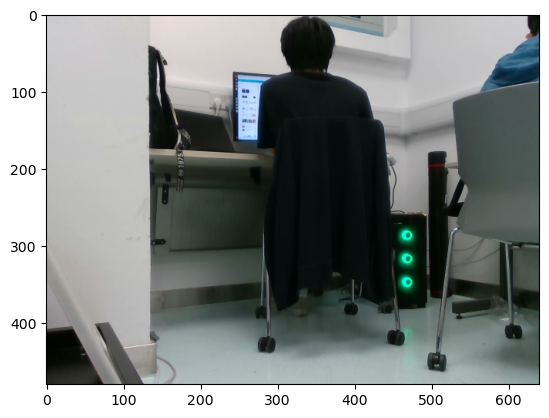

In [23]:
print(pil_image.size)
# display the image using matplotlib
import matplotlib.pyplot as plt
plt.imshow(pil_image)
# plt.imshow(image[0].permute(1, 2, 0).cpu())

In [24]:
# Before running this, add lang-seg folder to your python path
from LoadLSeg import *
import torchvision.transforms as transforms
# from PIL import Image # use PILImage instead
from test_lseg_zs import *

transform = transforms.Compose([
    transforms.Resize(480),           # Resize the shorter side to 480 while maintaining aspect ratio
    transforms.CenterCrop((480, 480)),  # Crop the center to 480x480
    transforms.ToTensor()            # Convert to tensor
])

image_tensor = transform(pil_image)
image_tensor.shape

torch.Size([3, 480, 480])

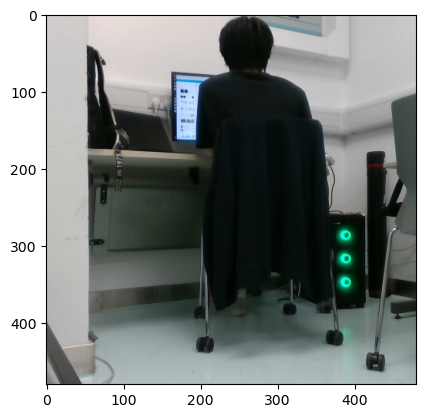

In [25]:
plt.imshow(image_tensor.permute(1, 2, 0))

In [26]:
torch.cuda.empty_cache()
with torch.no_grad():
    feat = model(image_tensor.unsqueeze(0).cuda())
feat.shape

torch.Size([480, 480, 512])

###############################################
searching for: blue bottle
###############################################
max value at (coordinate in pixel): row 339.0 col 374.0
max value at (coordinate %): 0.71 0.78


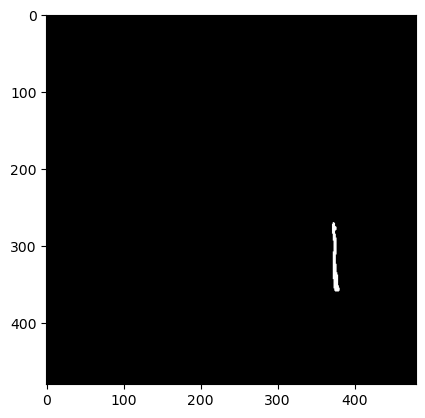

In [27]:
search = "blue bottle"
threshold = 0.99
text_feat1 = model.encode_text(search)
sim_image = feat.half() @ text_feat1.t()
sim_image[sim_image < sim_image.max()*threshold] = 0
display_img2 = sim_image.detach().cpu().numpy()
plt.imshow(display_img2, cmap='gray', vmin=display_img2.min(), vmax=display_img2.max())
# coordinates of the maximum value in the similarity image
print("###############################################")
print(f"searching for: {search}")
print("###############################################")
x, y = float((sim_image.argmax() // sim_image.shape[1]).detach().cpu()), float((sim_image.argmax() % sim_image.shape[1]).detach().cpu())
print("max value at (coordinate in pixel):", f"row {x}", f"col {y}")
print("max value at (coordinate %):", round(x/480,2), round(y/480, 2))

In [28]:
# print(feat_image[350, 350])
# print(feat_image.min())

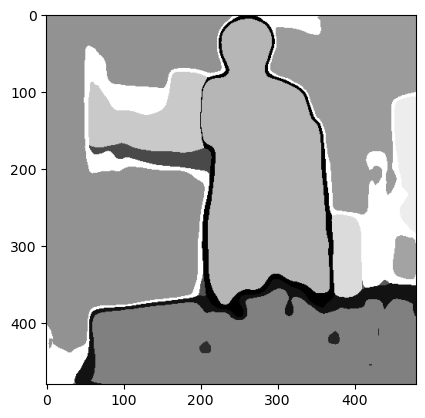

In [29]:
clustered_image = PCA_and_Cluster(feat)
plt.imshow(clustered_image, cmap='gray', vmin=clustered_image.min(), vmax=clustered_image.max())

In [30]:
key_pixels = obtain_key_pixels(feat, clustered_image)

In [31]:
key_points = rscalc.obtain_key_points(key_pixels)

In [32]:
update_pcfm(key_points, 1)

In [33]:
pcfm.keys()

dict_keys([(0.0, 0.0, 0.0), (1.0, -0.5, 0.5), (1.0, -0.5, -0.5), (1.5, -0.5, 0.0), (0.0, 0.0, -0.5), (2.0, -1.0, -0.5), (0.5, 0.0, -0.5), (0.5, -0.5, -0.5), (2.0, 1.0, 0.5), (1.5, 0.0, -0.5), (2.0, 0.0, -1.0), (2.0, 0.5, 0.0), (1.5, 0.0, -1.0), (2.0, 1.0, 0.0), (2.5, -0.5, 0.5), (1.5, 0.0, 0.0), (2.0, -0.5, -0.5), (1.0, -0.5, 0.0), (1.5, 0.5, 0.0)])

In [ ]:
indices

In [ ]:

executor.shutdown()
image_subscriber.destroy_node()
rscalc.destroy_node()
rclpy.shutdown()